In [2]:
import pandas as pd
import numpy as np 
import pymc as pm 
import arviz as az
import xarray as xr

import jax

import matplotlib.pyplot as plt
# Load the data
data = pd.read_csv('../data/nyc_regression_data.csv')
data

,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
4,1.0,WHITE,M,45-64,OTHER STATE LAWS,V
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [5]:
data_m_f = data[(data["law_cat_cd"].isin(["M", "F"]))]
data_m_f

,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
5,1.0,WHITE HISPANIC,M,25-44,DANGEROUS DRUGS,M
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [6]:
data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")

/tmp/ipykernel_17729/2538464095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")


# Number of crimes

In [7]:
data_grouped = data_m_f.groupby(["precinct"])["perp_race"].value_counts().reset_index(name="count")
data_grouped

,precinct,perp_race,count
0,1.0,NON BLACK,409
1,1.0,BLACK,392
2,5.0,NON BLACK,383
3,5.0,BLACK,367
4,6.0,BLACK,318
...,...,...,...
149,121.0,BLACK,369
150,122.0,NON BLACK,303
151,122.0,BLACK,99
152,123.0,NON BLACK,255


In [8]:
precinct_ids, unique_precincts = pd.factorize(data_grouped['precinct'], sort=True)

In [155]:
## number of crimes with precinct only

with pm.Model(coords={'precincts': unique_precincts}) as  precinct_count_model:
    # alpha = pm.Normal('alpha', mu=0, sigma=1.5)
    alpha = pm.Normal('alpha', mu=0, sigma=1.5, dims='precincts')
    precinct_id = pm.Data('precinct_id', precinct_ids)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(alpha[precinct_id]))
    
    crime = pm.Poisson('crime', lambda_, observed=data_grouped["count"])

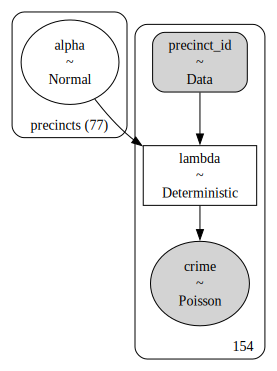

In [156]:
pm.model_to_graphviz(precinct_count_model)

In [157]:
with precinct_count_model:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, crime]


In [158]:
prior["beta_p"].stack(sample=("chain", "draw")).shape

KeyError: "No variable named 'beta_p'. Variables on the dataset include ['chain', 'draw', 'precincts', 'alpha', 'race', 'beta_r', 'lambda_dim_0', 'lambda']"

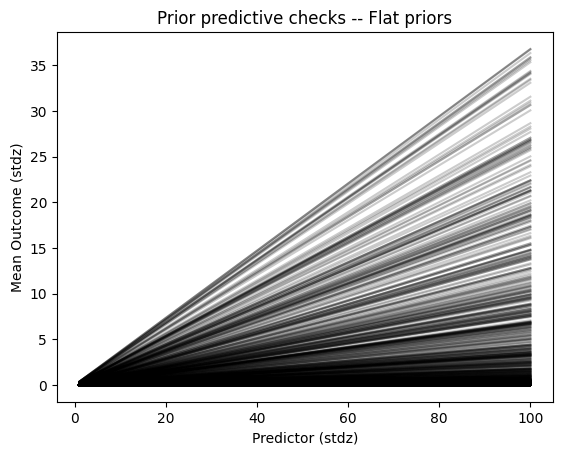

In [159]:
prior = prior_checks["prior"]

from scipy.stats import poisson

pois = poisson(mu=np.exp(prior["alpha"]).stack(sample=("chain", "draw")))

x = xr.DataArray(np.linspace(1, 100, 100), dims=["plot_dim"])


_, ax = plt.subplots()

ax.plot(x, np.outer(x,pois.pmf(x)), c="k", alpha=0.2)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");


In [160]:
with precinct_count_model:

    precinct_count_trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True), cores=4,nuts_sampler="numpyro")

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.11/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 2000/2000 [00:05<00:00, 373.24it/s, 7 steps of size 4.85e-01. acc. prob=0.85]


In [161]:
az.summary(precinct_count_trace, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[1.0],5.989,0.037,5.921,6.058,0.000,0.000,6705.0,2768.0,1.0
alpha[5.0],5.923,0.037,5.851,5.991,0.000,0.000,7002.0,3012.0,1.0
alpha[6.0],5.574,0.045,5.489,5.654,0.001,0.000,6565.0,2735.0,1.0
alpha[7.0],5.676,0.041,5.599,5.753,0.000,0.000,7012.0,3170.0,1.0
alpha[9.0],5.517,0.045,5.434,5.600,0.001,0.000,6636.0,2764.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha[115.0],6.434,0.029,6.380,6.491,0.000,0.000,6753.0,2854.0,1.0
alpha[120.0],6.531,0.027,6.479,6.580,0.000,0.000,6767.0,3068.0,1.0
alpha[121.0],5.974,0.035,5.910,6.040,0.000,0.000,5390.0,2992.0,1.0
alpha[122.0],5.296,0.051,5.205,5.394,0.001,0.000,5870.0,3071.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

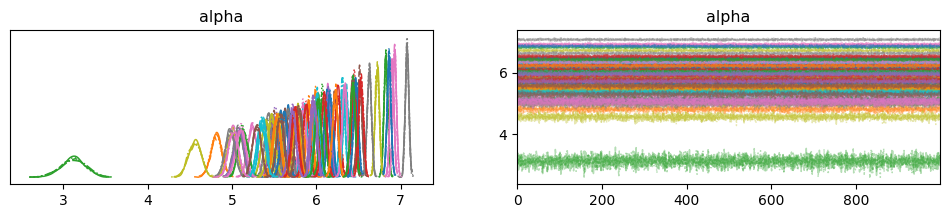

In [162]:
az.plot_trace(precinct_count_trace, var_names=["alpha"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

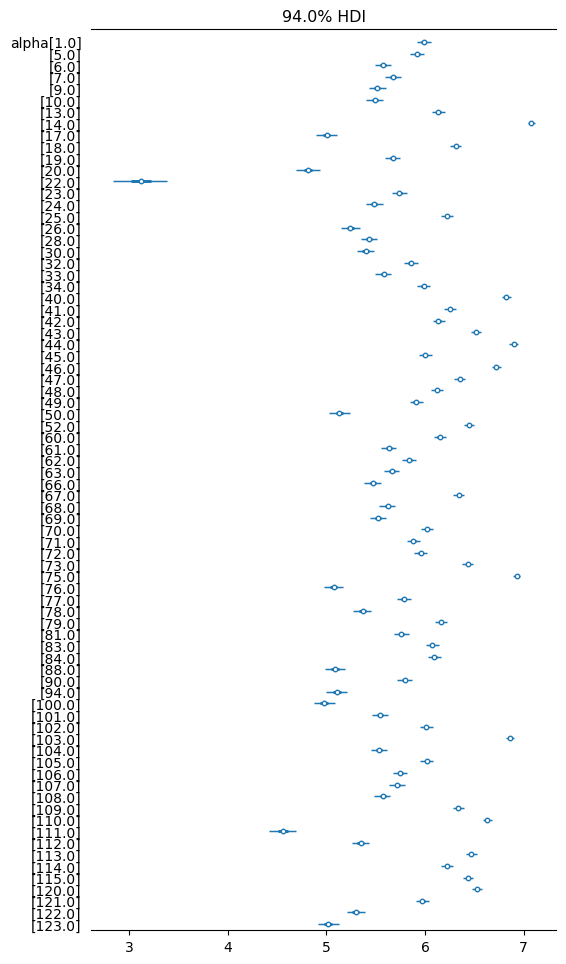

In [163]:
az.plot_forest(precinct_count_trace, combined=True, var_names=["alpha"], textsize=10)

## Precinct and Race

In [213]:
race_ids, unique_race = pd.factorize(data_grouped['perp_race'], sort=True)

unique_race
race_ids

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0])

In [215]:
data_grouped['perp_race']

0      NON BLACK
1          BLACK
2      NON BLACK
3          BLACK
4          BLACK
         ...    
149        BLACK
150    NON BLACK
151        BLACK
152    NON BLACK
153        BLACK
Name: perp_race, Length: 154, dtype: object

In [257]:
with pm.Model(coords={'precincts': unique_precincts, 'race': unique_race}) as  precinct_race_count_model:
    alpha = pm.Normal('alpha', mu=0, sigma=0.5, dims="precincts")
    beta_r = pm.Normal('beta_r', mu=15 , sigma=10, dims="race")
    precinct_id = pm.Data('precinct_id', precinct_ids)
    race_id = pm.Data('race_id', race_ids)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(alpha[precinct_id] + beta_r[race_id]))
    
    crime = pm.Poisson('crime', lambda_, observed=data_grouped["count"])

In [258]:
with precinct_race_count_model:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta_r, crime]


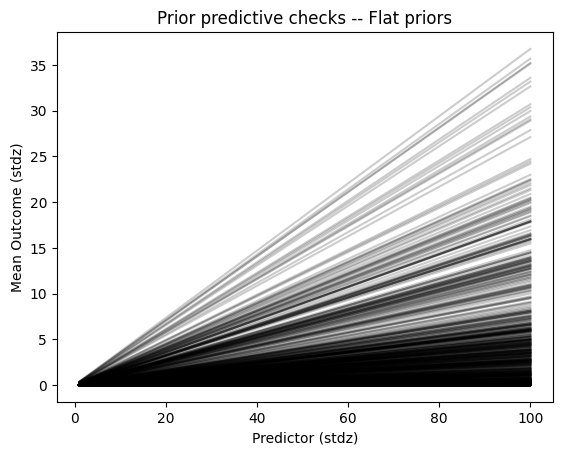

In [245]:
prior = prior_checks["prior"]

pois = poisson(mu=np.exp(prior["alpha"] + prior["beta_r"]).stack(sample=("chain", "draw")))

x = xr.DataArray(np.linspace(1, 100, 100), dims=["plot_dim"])


_, ax = plt.subplots()

ax.plot(x, np.outer(x,pois.pmf(x)), c="k", alpha=0.2)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");


In [246]:
with precinct_race_count_model:
    precinct_race_count_trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=4, idata_kwargs=dict(log_likelihood=True), nuts_sampler="numpyro")

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.11/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 3000/3000 [00:23<00:00, 126.94it/s, 31 steps of size 1.11e-01. acc. prob=0.92]
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [247]:
az.summary(precinct_race_count_trace, var_names=["alpha", "beta_r"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[1.0],0.146,0.064,0.023,0.267,0.005,0.004,151.0,447.0,1.02
alpha[5.0],0.080,0.065,-0.043,0.202,0.005,0.004,153.0,419.0,1.02
alpha[6.0],-0.265,0.068,-0.393,-0.140,0.005,0.004,162.0,563.0,1.02
alpha[7.0],-0.163,0.067,-0.283,-0.030,0.005,0.004,164.0,567.0,1.02
alpha[9.0],-0.320,0.069,-0.447,-0.190,0.005,0.004,170.0,603.0,1.02
...,...,...,...,...,...,...,...,...,...
alpha[121.0],0.131,0.064,0.015,0.256,0.005,0.004,150.0,550.0,1.02
alpha[122.0],-0.538,0.073,-0.675,-0.404,0.005,0.004,194.0,713.0,1.02
alpha[123.0],-0.809,0.078,-0.960,-0.666,0.005,0.004,230.0,919.0,1.01
beta_r[BLACK],5.968,0.054,5.868,6.069,0.005,0.004,105.0,276.0,1.03


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_r'}>,
        <Axes: title={'center': 'beta_r'}>]], dtype=object)

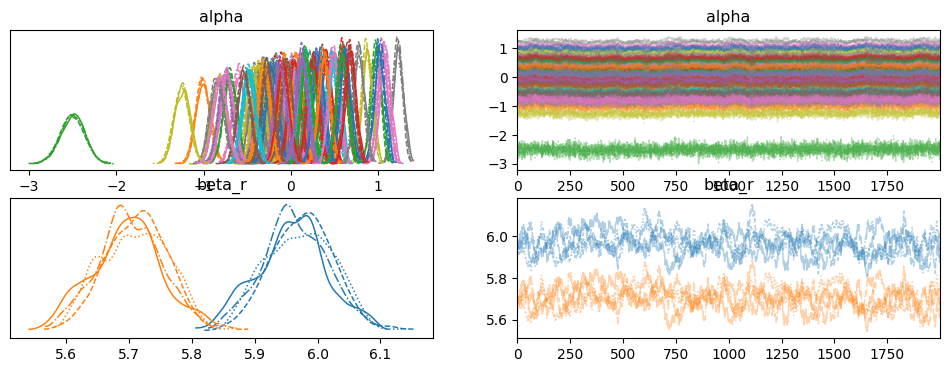

In [248]:
az.plot_trace(precinct_race_count_trace, var_names=["alpha", "beta_r"])

Text(0.5, 1.0, 'Precinct & race City Crime Count')

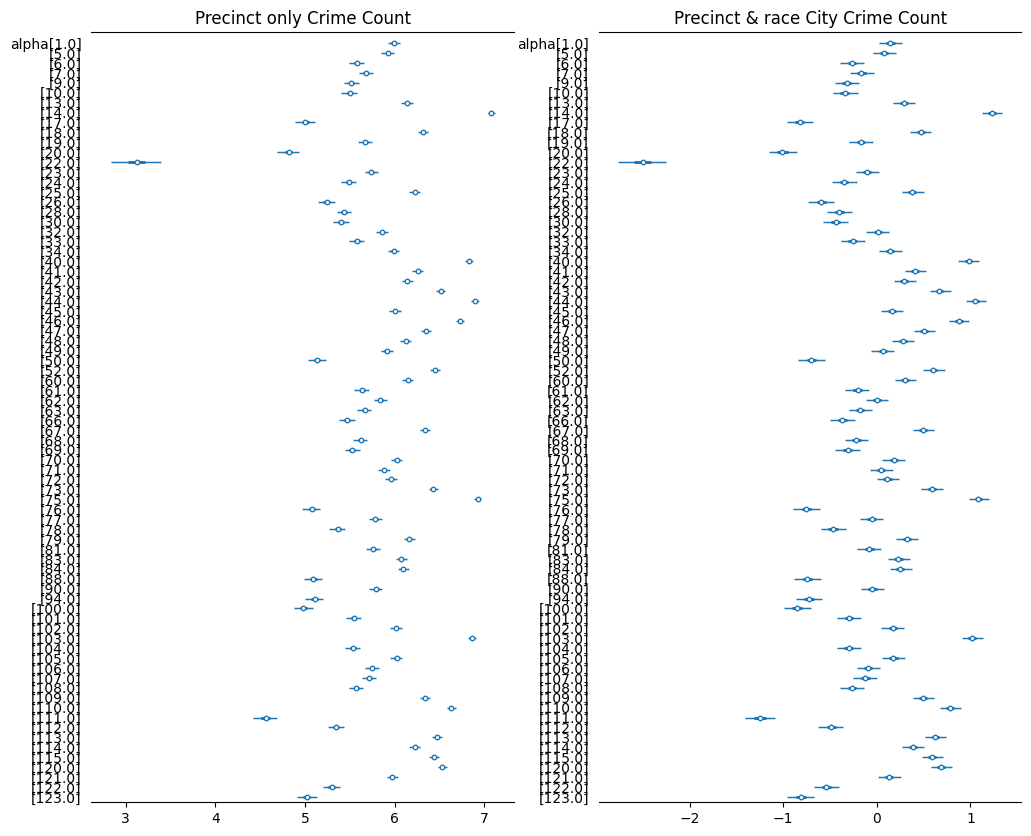

In [259]:
_, ax = plt.subplots(1, 2, figsize=(12, 10))

az.plot_forest(precinct_count_trace, combined=True, var_names=["alpha"], ax=ax[0], textsize=10)
ax[0].set_title("Precinct only Crime Count")
az.plot_forest(precinct_race_count_trace, combined=True, var_names=["alpha"], ax=ax[1], textsize=10)
ax[1].set_title("Precinct & race City Crime Count")

In [ ]:
#